# 1. GPU 설정

- Google Colaboratory에서 딥러닝 학습을 진행하실 때에는 반드시 GPU 설정이 제대로 되어있는지 확인해야 합니다.
- 위의 메뉴에서 '런타임 - 런타임 유형 변경 - 하드웨어 가속기'에서 GPU를 선택해줍니다.

# 2. Pytorch 설치

- Google Colaboratory에서 최근 들어 Pytorch도 기본적으로 제공을 하기 시작해서 이 과정은 생략해도 됩니다. 

In [0]:
!pip install torch
!pip install torchvision

# 3. Import

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰텐데요, 이러한 데이터는 표준 Python 패키지를 사용하여 불러온 후 NumPy 배열로 변환하면 됩니다. 그리고 그 배열을 torch.*Tensor 로 변환하면 됩니다.

- 이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
- 오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
- 텍스트의 경우에는 그냥 Python이나 Cython의 것들을 사용하거나, NLTK나 SpaCy도 좋습니다.

특별히 영상 분야를 위해서는 torchvision 이라는 패키지를 만들어두었는데요, 여기에는 Imagenet이나 CIFAR10, MNIST 등과 같은 일반적으로 사용하는 데이터셋을 불러오는 함수들(data loaders)이나 데이터 변환기가 포함되어 있습니다.

In [0]:
import torch
import torchvision

import torchvision.transforms as transforms
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

- CUDA (Computed Unified Device Architecture) 는 NVIDIA 사에서 개발한 GPU (Graphic Processing Unit)개발 툴

In [0]:
# Gets the name of a device.
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

# Monitoring GPU
print("GPU Information")
!nvidia-smi

Tesla K80
1
GPU Information
Tue Aug  6 11:27:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

# 4. Data

- Pytorch의 데이터는 크게 __'Dataset'__과 __'Data Loader'__로 구분되어 있습니다.
- 1) __Dataset__ : 학습에 사용한 데이터셋 전체를 의미합니다. <br>  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Dataset의 파라미터 중 하나인 __transform__을 통해 전체 데이터에 일괄적으로 변형을 줄 수 있습니다.
<br> 
- 2) __Data Loader__ : Dataset에서 데이터를 읽어와 모델에 입력으로 제공해주는역할을 합니다. 

이번 실습에는 __CIFAR 10__이라는 데이터를 사용하도록 하겠습니다.
<br>CIFAR 10은 Pytorch에서 기본적으로 제공하는 데이터셋이기 때문에 별도로 데이터를 다운로드 해줄 필요가 없습니다.
-  '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)', '사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'. 그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32

![CIFAR_10](http://solarisailab.com/wp-content/uploads/2017/06/cifar-10_labels.png)

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다. 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환하겠습니다.



In [0]:
# Transform
transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
###########################
# Train Dataset & Loader #
##########################

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download=True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

##########################
# Test Dataset & Loader #
#########################

testset = torchvision.datasets.CIFAR10(root='./data', train = False, download=True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

0it [00:00, ?it/s]

 99%|█████████▉| 169598976/170498071 [00:11<00:00, 16851366.57it/s]

Files already downloaded and verified


In [0]:
#####################
# CIFAR10의 클래스 #
####################

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

truck   car  ship plane


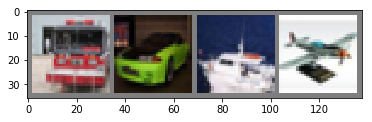

In [0]:
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
  

# 5. 모델(Network)

- 이번 실습에는 Classification 모델 중 하나인 __'VGG16'__을 사용하도록 하겠습니다.
- 마찬가지로 Pytorch는 많은 딥러닝 모델도 기본적으로 제공하기 때문에 코드 한 줄로 편리하게 모델을 불러올 수 있습니다.
<table><tr>
> <td> <img src="https://docs.google.com/uc?export=download&id=1uvdiDG74Kcgn5swsZY8pLDo0bwuQJ7jr" alt="no_image" style="width: 480px;"/> </td>
> <td> <img src="https://docs.google.com/uc?export=download&id=1fFqTJkAsN2zuG2cN-r24t1ajIPFaPTcV" alt="no_image" style="width: 320px;"/> </td>
> </tr></table>
>
> <font size="0.5"> Figure from https://www.quora.com/What-is-the-VGG-neural-network </font>


CNN(Convolution Neural Network) 정의

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    '''
    self.Feature_extractor = nn.Sequential(
        
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        
        
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        
        
        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        
        
        nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        
        
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
    
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
    
    self.classifier = nn.Sequential(   
        nn.Linear(in_features=25088, out_features=4096, bias=True),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=4096, out_features=1000, bias=True)
    )
    '''
    self.conv1 = nn.Conv2d(3, 8, 5)
    self.conv2 = nn.Conv2d(8, 16, 5)
    
    self.pool = nn.MaxPool2d(2,2)
    
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  # forward 함수만 정의하고 나면, (변화도를 계산하는) backward 함수는 autograd 를 사용하여 자동으로 정의    
  def forward(self, x):
    x = F.relu(self.pool(self.conv1(x)))
    x = F.relu(self.pool(self.conv2(x)))
    
    x = x.view(-1, 16*5*5)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    
    
    
    '''
    x = self.Feature_extractor(x)
    x = self.avgpool(x)
    x = self.classifier(x)
    '''
    return x
    
net = Net()

In [0]:
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Loss function 과 Optimizer 정의

- Multi-label Classification에서 가장 흔히 사용하는 loss 중 하나인 __'Cross Entropy Loss'__를 사용하도록 하겠습니다.
- 그리고 Optimizer는 주로 __'Adam'__과 __'SGD (Stochastic Gradient Descent)'__가 사용되고 이번 실습에는 __SGD__를 사용하겠습니다.

In [0]:
##################
# Loss Function #
#################
criterion = nn.CrossEntropyLoss()

##############
# Optimizer #
#############
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

# torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1)
 # Assuming optimizer uses lr = 0.05 for all groups
#>>>  lr = 0.05     if epoch < 30
#>>>  lr = 0.005    if 30 <= epoch < 60
#>>>  lr = 0.0005   if 60 <= epoch < 90
#>>>  ...

# 6. GPU in Pytorch

- Pytorch에서 GPU를 사용하려면 __모델과 데이터를 GPU 설정(Cuda)으로 바꿔주어야 합니다.__
- Tensor를 GPU로 옮겼던 것처럼, 신경망을 GPU로 옮길 수 있습니다.
- 먼저, CUDA를 사용할 수 있는 경우 첫번째 CUDA 장치(Device)를 사용하도록 설정합니다:

 이 메소드(Method)들은 재귀적으로 모든 모듈로 가서 매개변수와 버퍼를 CUDA tensor로 변경
 - net.to(device)
 - inputs, labels = inputs.to(device), labels.to(device)

여러개의 GPU에서 학습하기
- 배우고 싶으시면 Science team으로!

In [0]:
# GPU 사용 가능 여부를 바탕으로 'GPU(cuda)'와 'CPU' 중 어떤 것을 바탕으로 학습을 할지 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# GPU 설정
net.to(device)

cuda


Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# 7. Training

1 Epoch : 모든 dataset을 1번 학습
1 Iteration(=step) : 1회 학습(batch size 단위)
mini_batch : dataset을 batch size 크기로 쪼개서 학습

- ex) 총 data = 100개, batch size= 10이면, 1 iteration = 10개 데이터 학습, 1 epoch = 100/batch size = 10 iteration

In [0]:
##################
# Declare Epoch #
#################
epochs = 2

#############
# Training #
############
for epoch in range(epochs):
  print('\n===> Epoch [%d/%d]' % (epoch+1, epochs))
  
  running_loss = 0.0
  
  for i, data in enumerate(trainloader, 0):
    
    # Data Load
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    
    # Backward
    loss.backward()
    
    # Optimize
    optimizer.step()
    
    # Print statistics
    running_loss += loss.item()
    
    # Print every 2000 mini-batches
    if i % 2000 == 1999 :
      print('      - Iteration [%5d / %5d] --- Loss: %.3f' %
            (i+1, len(trainloader), running_loss / 2000))
      running_loss = 0.0


===> Epoch [1/2]
      - Iteration [ 2000 / 12500] --- Loss: 2.227
      - Iteration [ 4000 / 12500] --- Loss: 1.880
      - Iteration [ 6000 / 12500] --- Loss: 1.680
      - Iteration [ 8000 / 12500] --- Loss: 1.562
      - Iteration [10000 / 12500] --- Loss: 1.503
      - Iteration [12000 / 12500] --- Loss: 1.419

===> Epoch [2/2]
      - Iteration [ 2000 / 12500] --- Loss: 1.385
      - Iteration [ 4000 / 12500] --- Loss: 1.346
      - Iteration [ 6000 / 12500] --- Loss: 1.288
      - Iteration [ 8000 / 12500] --- Loss: 1.278
      - Iteration [10000 / 12500] --- Loss: 1.280
      - Iteration [12000 / 12500] --- Loss: 1.276


# 8. Test

어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))



# Freeze model
with torch.no_grad(): 
  
  for data in testloader:
        
        # Data Load
        images, labels = data
        
        images, labels = images.to(device), labels.to(device)
        
        # Predict
        outputs = net(images)
        _, predicted = torch.max(outputs, 1) # Returns a namedtuple (values, indices)
        
        # Calculuate
        c = (predicted == labels).squeeze() # Returns a tensor with all the dimensions of input of size 1 removed.
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item() # Python number from a tensor containing a single value:
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 68 %
Accuracy of  bird : 41 %
Accuracy of   cat : 35 %
Accuracy of  deer : 60 %
Accuracy of   dog : 50 %
Accuracy of  frog : 65 %
Accuracy of horse : 64 %
Accuracy of  ship : 67 %
Accuracy of truck : 68 %
